In [1]:
# TensorFlow 라이브러리 불러오기

import tensorflow as tf

tf.__version__

'1.3.0'

In [2]:
# NumPy 라이브러리 불러오기

import numpy as np

np.__version__

'1.13.1'

In [3]:
# Matplotlib 라이브러리 불러오기

import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'2.0.2'

In [4]:
# MNIST 데이터 로딩

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/mnist-data')

Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


In [5]:
# 훈련 데이터 확인

mnist.train.images.shape, mnist.train.labels.shape

((55000, 784), (55000,))

In [6]:
# 테스트 데이터 확인

mnist.test.images.shape, mnist.test.labels.shape

((10000, 784), (10000,))

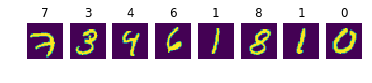

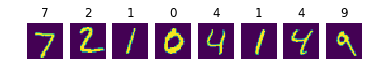

In [7]:
# 손글씨 이미지 시각화

def draw_image(images, labels):
    fig, axes = plt.subplots(1, images.shape[0])
    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(images[i].reshape(28, 28))
        ax.set_title(labels[i])
    plt.show()

draw_image(mnist.train.images[:8],
           mnist.train.labels[:8])

draw_image(mnist.test.images[:8],
           mnist.test.labels[:8])

In [8]:
# 신경망 모델 생성

# 데이터

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int64, [None])

# 입력 노드: 28 * 28개 / 출력 노드: 10개

w = tf.Variable(tf.truncated_normal([28 * 28, 10], stddev=0.1))
b = tf.Variable(tf.truncated_normal([10], stddev=0.1))

# f( W * x + b )

u = tf.matmul(x, w) + b
z = tf.nn.softmax(u)

In [9]:
# 손실/비용 함수

loss = tf.nn.softmax_cross_entropy_with_logits(
    logits=u, # softmax 적용하지 않은 값
    labels=tf.one_hot(y, 10)
)

# 최적화

learning_rate = 0.3
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [10]:
# 예측

predict = tf.argmax(z, axis=1)

# 정확도

correct = tf.equal(y, predict)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
# TensorFlow 세션 준비

session = tf.Session()
session.run(tf.global_variables_initializer())

In [12]:
# 정확도 출력

test_feed = {
    x: mnist.test.images,
    y: mnist.test.labels
}

def print_accuracy(index):
    print('{} - {}'.format(index, session.run(accuracy, feed_dict=test_feed)))

In [13]:
# 훈련

print_accuracy(0)

for i in range(100):
    for j in range(100):
        x_data, y_data = mnist.train.next_batch(200)
        train_feed = {
            x: x_data,
            y: y_data
        }
        session.run(train, feed_dict=train_feed)
    print_accuracy(i + 1)

print('Done!')

0 - 0.08900000154972076
1 - 0.824400007724762
2 - 0.8884000182151794
3 - 0.6150000095367432
4 - 0.8276000022888184
5 - 0.8989999890327454
6 - 0.8495000004768372
7 - 0.8657000064849854
8 - 0.9035000205039978
9 - 0.763700008392334
10 - 0.7735000252723694
11 - 0.7264000177383423
12 - 0.9039000272750854
13 - 0.8851000070571899
14 - 0.90829998254776
15 - 0.895799994468689
16 - 0.892300009727478
17 - 0.9064000248908997
18 - 0.8985999822616577
19 - 0.9068999886512756
20 - 0.8762999773025513
21 - 0.9104999899864197
22 - 0.896399974822998
23 - 0.906499981880188
24 - 0.9156000018119812
25 - 0.8291000127792358
26 - 0.9082000255584717
27 - 0.8551999926567078
28 - 0.8774999976158142
29 - 0.9021000266075134
30 - 0.8932999968528748
31 - 0.7091000080108643
32 - 0.9168999791145325
33 - 0.8508999943733215
34 - 0.9110000133514404
35 - 0.9111999869346619
36 - 0.913100004196167
37 - 0.8565000295639038
38 - 0.8385999798774719
39 - 0.9118000268936157
40 - 0.873199999332428
41 - 0.8878999948501587
42 - 0.8960

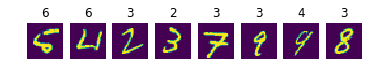

In [14]:
# 오답 시각화

c, p = session.run([correct, predict], feed_dict=test_feed)

images = mnist.test.images[~c]
labels = p[~c]

draw_image(images[:8], labels[:8])

In [15]:
# TensorFlow 그래프 초기화

tf.reset_default_graph()

In [16]:
# CNN 모델 생성

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int64, [None])

x_2d = tf.reshape(x, [-1, 28, 28, 1])

print('입력', x_2d.shape)

# 1단계 -> 4채널 14 * 14

c1 = tf.contrib.layers.conv2d(x_2d, 4, [5, 5])
p1 = tf.contrib.layers.max_pool2d(c1, [2, 2])

print('1단계', p1.shape)

# 2단계 -> 8채널 7 * 7

c2 = tf.contrib.layers.conv2d(p1, 8, [5, 5])
p2 = tf.contrib.layers.max_pool2d(c2, [2, 2])

print('2단계', p2.shape)

# Flat -> 7 * 7 * 8

flat = tf.contrib.layers.flatten(p2)

print('모두 연결', flat.shape)

# 중간층 -> 출력 노드: 200개

hidden = tf.contrib.layers.fully_connected(flat, 200)

print('중간', hidden.shape)

# 출력 노드: 10개

u = tf.layers.dense(hidden, 10)
z = tf.nn.softmax(u)

print('출력', z.shape)

입력 (?, 28, 28, 1)
1단계 (?, 14, 14, 4)
2단계 (?, 7, 7, 8)
모두 연결 (?, 392)
중간 (?, 200)
출력 (?, 10)


In [17]:
# 손실/비용 함수

loss = tf.nn.softmax_cross_entropy_with_logits(
    logits=u, # softmax 적용하지 않은 값
    labels=tf.one_hot(y, 10)
)

# 최적화 - Adam algorithm

learning_rate = 0.0001
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# 예측

predict = tf.argmax(z, axis=1)

# 정확도

correct = tf.equal(y, predict)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
# TensorFlow 세션 준비

session = tf.Session()
session.run(tf.global_variables_initializer())

# 정확도 출력

test_feed = {
    x: mnist.test.images,
    y: mnist.test.labels
}

def print_accuracy(index):
    print('{} - {}'.format(index, session.run(accuracy, feed_dict=test_feed)))

In [ ]:
# 훈련

print_accuracy(0)

for i in range(100):
    for j in range(100):
        x_data, y_data = mnist.train.next_batch(200)
        train_feed = {
            x: x_data,
            y: y_data
        }
        session.run(train, feed_dict=train_feed)
    print_accuracy(i + 1)

print('Done!')

0 - 0.08730000257492065
1 - 0.6420000195503235
2 - 0.8306999802589417
3 - 0.8762999773025513
4 - 0.9021999835968018
5 - 0.9132000207901001
6 - 0.9207000136375427
7 - 0.9283999800682068
8 - 0.9323999881744385
9 - 0.9355000257492065
10 - 0.9391000270843506
11 - 0.942799985408783
12 - 0.9445000290870667
13 - 0.9480000138282776
14 - 0.9505000114440918
15 - 0.9495999813079834
16 - 0.9521999955177307
17 - 0.9550999999046326
18 - 0.9560999870300293
19 - 0.9581999778747559
20 - 0.9595999717712402
21 - 0.961899995803833
22 - 0.9617000222206116
23 - 0.9623000025749207
24 - 0.9638000130653381
25 - 0.965399980545044
26 - 0.9660999774932861
27 - 0.96670001745224
28 - 0.9692000150680542
29 - 0.968500018119812
30 - 0.9699000120162964
31 - 0.970300018787384
32 - 0.9707000255584717
33 - 0.97079998254776
34 - 0.9735999703407288
35 - 0.9729999899864197
36 - 0.9733999967575073
37 - 0.9735000133514404
38 - 0.9746000170707703
39 - 0.9742000102996826
40 - 0.9765999913215637
41 - 0.9758999943733215


In [ ]:
# 오답 시각화

c, p = session.run([correct, predict], feed_dict=test_feed)

images = mnist.test.images[~c]
labels = p[~c]

draw_image(images[:8], labels[:8])